In [1]:
import shutil, os, sys, io, random, math
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Reshape, Flatten, Activation, UpSampling2D, Dense, AveragePooling2D, add, Lambda, GaussianNoise
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import ReLU, LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform, RandomNormal
from keras.utils import multi_gpu_model

import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/srresgan/')
# os.chdir('\\Users\\pro18\\Documents\\py\\Keras-GAN\\wgan_gp')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from wasserstein_loss import WassersteinLoss, GradientPenaltyLoss, loss_func_dcgan_dis_real, loss_func_dcgan_dis_fake

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

# ---------------------
#  Parameter
# ---------------------
gpu_count = 1
resume = 0
dataset = np.load('../datasets/lfw32.npz')['arr_0']
modelname = 'srres_dragan4_32n5x4'
# size = 128
# dataset = np.ones((1000, size, size, 3), dtype=np.float32)

In [2]:
def Gen_ResBlock(input_layer, filters, kernal_size=3, strides=1):
    initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)

    x = Conv2D(filters = filters, 
               kernel_size = kernal_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(input_layer)
    x = BatchNormalization(momentum = 0.9)(x)
    x = Activation("relu")(x)
    x = Conv2D(filters = filters, 
               kernel_size = kernal_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(x)
    x = BatchNormalization(momentum = 0.9)(x)
    output_layer = add([input_layer, x])
    
    return output_layer


def pixel_shuffler(input_layer):
    input_shape = K.int_shape(input_layer)
    batch_size, h, w, c = input_shape
    # batch_size is None maybe..
    rh, rw = 2, 2
    oh, ow = h * rh, w * rw
    oc = c // (rh * rw)

    # x = Reshape((h, w, rh, rw, oc))(input_layer) -> Mod
    x = Reshape((h, w, oc, rh, rw))(input_layer)
    # calculated = K.sqrt(model_input + 1.0) 
    # calculated = Lambda(lambda x: K.sqrt(x + 1.0), output_shape=(10,))(model_input)
    # x = K.permute_dimensions(x, (0, 1, 3, 2, 4, 5))
    x = Lambda(lambda x: K.permute_dimensions(x, (0, 1, 4, 2, 5, 3)), 
               output_shape=(h, rh, w, rw, oc))(x)
    output_layer = Reshape((oh, ow, oc))(x)
    
    return output_layer


def CBR(input_layer, filters, kernel_size=3, strides=1):
    # initializer = glorot_uniform(seed=None)
    initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)
    
    x = UpSampling2D(size=(2, 2))(input_layer)
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(x)
    # x = pixel_shuffler(x)
    # Need to test F.unpooling_2d for pixel_shuffler
    x = BatchNormalization(momentum = 0.9)(x)
    output_layer = Activation("relu")(x)
    
    return output_layer


def Dis_ResBlock(input_layer, filters, kernel_size=3, strides=1):
    # initializer = glorot_uniform(seed=None)
    initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)
    
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(input_layer)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(x)
    x = add([input_layer, x])
    output_layer = LeakyReLU(alpha = 0.2)(x)
    
    return output_layer


def SE(input_layer, r=16):
    initializer = glorot_uniform(seed=None)
    input_shape = K.int_shape(input_layer)
    batch_size, h, w, c = input_shape
    # batch_size is None maybe..
    
    #x = AveragePooling2D(pool_size=(h, w), strides=None, padding='valid')(input_layer)
    x = AveragePooling2D(pool_size=(h, w), strides=1, padding='valid')(input_layer)
    x = Reshape((c,))(x)
    x = Dense(int(c/r), kernel_initializer=initializer)(x)
    x = Activation("relu")(x)
    x = Dense(c, kernel_initializer=initializer)(x)
    x = Activation("sigmoid")(x)
    # x = K.expand_dims(x, axis=2)
    # x = K.repeat_elements(x, rep=h, axis=2)
    x = Lambda(lambda x: K.expand_dims(x, axis=2),
               output_shape=(c, 1))(x)
    x = Lambda(lambda x: K.repeat_elements(x, rep=h, axis=2),
               output_shape=(c, h))(x)
    x = Lambda(lambda x: K.expand_dims(x, axis=3),
               output_shape=(c, h, 1))(x)
    x = Lambda(lambda x: K.repeat_elements(x, rep=w, axis=3),
               output_shape=(c, h, w))(x)
    output_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)), 
                          output_shape=(h, w, c))(x)
    
    return output_layer
    

def Dis_SEResBlock(input_layer, filters, kernel_size=3, strides=1):
    initializer = glorot_uniform(seed=None)
    
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(input_layer)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, strides = strides, padding = "same", 
               kernel_initializer=initializer)(x)
    x = SE(x)
    x = add([input_layer, x])
    output_layer = LeakyReLU(alpha = 0.2)(x)    
    
    return output_layer

In [3]:
class DRAGAN():
    def __init__(self, dataset, gpu_count=1, resume=0):
        # ---------------------
        #  Parameter
        # ---------------------
        self.dataset = dataset
        self.gpu_count = gpu_count
        self.resume = resume
                
        self.img_rows = dataset.shape[1]
        self.img_cols = dataset.shape[2]
        self.channels = dataset.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        if self.img_rows == 128:
            self.input_rows = 16
            self.input_cols = 16            
        else:
            self.input_rows = 4
            self.input_cols = 4
        self.latent_dim = 128  # Noise dim
        
        self.n_critic = 5
        self.λ = 1
        optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

        # ---------------------
        #  Load models
        # ---------------------
        self.critic = self.build_critic()
        self.generator = self.build_generator()
        if self.resume != 0:
            self.critic = load_model('./saved_model/'+modelname+'_critic_'+str(self.resume)+'epoch.h5')
            self.generator = load_model('./saved_model/'+modelname+'_gen_'+str(self.resume)+'epoch.h5')  
        
        #-------------------------------
        # Compile Critic
        #-------------------------------    
        generated_samples = Input(shape=self.img_shape) 
        critic_output_from_generated_samples = self.critic(generated_samples)
        
        real_samples = Input(shape=self.img_shape)        
        critic_output_from_real_samples = self.critic(real_samples)

        averaged_samples = Input(shape=self.img_shape)
        critic_output_from_averaged_samples = self.critic(averaged_samples)

        partial_gp_loss = partial(GradientPenaltyLoss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[generated_samples, 
                                          real_samples,
                                          averaged_samples],
                                  outputs=[critic_output_from_generated_samples, 
                                           critic_output_from_real_samples,
                                           critic_output_from_averaged_samples])
        
        # loss_dis = loss_func_dcgan_dis_real(y_dis) + loss_func_dcgan_dis_fake(y_fake) + loss_grad
        # loss_gen = loss_func_dcgan_dis_real(y_fake)
        
        if self.gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=self.gpu_count)
        self.critic_model.compile(optimizer=optimizer, 
                                  loss=[loss_func_dcgan_dis_fake, 
                                        loss_func_dcgan_dis_real,
                                        partial_gp_loss])

        # print('Critic Summary:')
        # self.critic.summary()       
        
        #-------------------------------
        # Compile Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
                    
        generator_input = Input(shape=(self.latent_dim,))
        generator_layers = self.generator(generator_input)
        critic_layers_for_generator = self.critic(generator_layers)
        
        self.generator_model = Model(inputs=[generator_input], 
                                     outputs=[critic_layers_for_generator])
        if self.gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=self.gpu_count)
        self.generator_model.compile(optimizer=optimizer,
                                     loss=loss_func_dcgan_dis_real)        

        # print('Genarator Summary:')
        # self.generator.summary()     

    def build_generator(self):
        base = 64
        # initializer = glorot_uniform(seed=None)
        initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)

        input_layer = Input(shape=(self.latent_dim,))
        x = Dense(base*self.input_rows*self.input_cols, kernel_initializer=initializer)(input_layer)
        x = BatchNormalization(momentum = 0.9)(x)
        x = Activation("relu")(x)
        x1 = Reshape((self.input_rows, self.input_cols, base))(x) 
        x = Gen_ResBlock(x1, base)
        x = Gen_ResBlock(x, base)
        x = Gen_ResBlock(x, base)
        x = Gen_ResBlock(x, base)
        x = Conv2D(filters = base, 
                   kernel_size = 3, strides = 1, padding = "same", 
                   kernel_initializer=initializer)(x)        
        x = BatchNormalization(momentum = 0.9)(x)
        x = Activation("relu")(x)
        x = add([x1, x])
        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            # x = CBR(x, base)
            x = CBR(x, base*4)
        x = Conv2D(filters = 3, 
                   kernel_size = math.ceil(9 * self.img_rows / 128), 
                   strides = 1, padding = "same", 
                   kernel_initializer=initializer)(x)
        output_layer = Activation('tanh')(x)
        
        model = Model(inputs = input_layer, outputs = output_layer)
        print('Generator Summary:')
        model.summary()
        return model
    
    def build_critic(self):
        base = 16
        # initializer = glorot_uniform(seed=None)
        initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)
        input_layer = Input(shape = self.img_shape)
        input_shape = K.int_shape(input_layer)
        batch_size, h, w, c = input_shape
        
        x = GaussianNoise(stddev=0.1)(input_layer)
        x = Conv2D(filters = base, 
                   kernel_size = 4, strides = 2, padding = "same", 
                   kernel_initializer=initializer)(x)        
        x = LeakyReLU(alpha = 0.2)(x)
        for i in range(int(math.log(self.img_rows, 2) - 2)): # 128=2^7
            if self.img_rows / (2 ** (i + 2)) >=  16: #2^7/2^(1+2)=2^4
                kernel_size = 4
            else:
                kernel_size = 3
            x = Dis_ResBlock(x, base * 2**i)
            x = Dis_ResBlock(x, base * 2**i)        
            x = Conv2D(filters = base * 2**(i+1), 
                       kernel_size = kernel_size, 
                       strides = 2, padding = "same", 
                       kernel_initializer=initializer)(x)        
            x = LeakyReLU(alpha = 0.2)(x)  
        x = Flatten()(x)
        output_layer = Dense(1, kernel_initializer=initializer)(x)
        
        model = Model(inputs = input_layer, outputs = output_layer)
        print('Critic Summary:')
        model.summary()
        return model

    def train(self, epochs, batch_size, sample_interval=5000):       
        # ---------------------
        #  for Logging
        # ---------------------
        target_dir = "./search/log_"+modelname
        seed = 0
        image_num = 5       
        np_samples = []
        
        # Load suspended training weights
        if self.resume != 0:
            np_samples_npz = np.load('./saved_model/'+modelname+'_sample_'+str(self.resume)+'epoch.npz')
            for i, np_sample in enumerate(np_samples_npz):
                np_samples.append(np_sample)
        else:            
            shutil.rmtree(target_dir, ignore_errors=True)
            os.mkdir(target_dir)
                
        self.logger = TensorBoardLogger(log_dir=target_dir)            
        
        # ---------------------
        #  Training
        # ---------------------
        # Rescale the dataset -1 to 1 
        X_train = self.dataset / 127.5 - 1.0

        # Adversarial ground truths
        minus = -np.ones((batch_size, 1), dtype=np.float32)
        plus = np.ones((batch_size, 1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in tqdm(range(self.resume, self.resume + epochs + 1)):
            for _ in range(self.n_critic):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise, batch_size=batch_size)
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_imgs = X_train[idx]
                               
                # ε = np.random.uniform(size=(batch_size, 1,1,1))
                # ave_imgs = ε * real_imgs + (1-ε) * gen_imgs
                ave_imgs = real_imgs + 0.5 * np.random.random(real_imgs.shape) * real_imgs.std() 
                
                # Train Critic
                d_loss = self.critic_model.train_on_batch([gen_imgs, real_imgs, ave_imgs], 
                                                          [plus, plus, dummy])

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.generator_model.train_on_batch(noise, plus)

            # ---------------------
            #  Logging
            # ---------------------
            # Backup Model
            '''
            if epoch != resume and epoch % sample_interval == 0:
                self.critic.save('./saved_model/'+modelname+'_critic_'+str(self.resume)+'epoch.h5')
                self.generator.save('./saved_model/'+modelname+'_gen_'+str(self.resume)+'epoch.h5')
                np.savez_compressed('./saved_model/'+modelname+'_sample_'+str(self.resume)+'epoch.npz', np_samples)
            '''
            # Log Loss & Histgram
            logs = {
                "loss/Critic": d_loss[0],
                "loss/Generator": g_loss,
                "loss_Critic/D_gen": d_loss[1],
                "loss_Critic/D_real": d_loss[2],
                "loss_Critic/gradient_penalty": d_loss[3],
                "loss_Critic/total_loss": d_loss[1] + d_loss[2] + d_loss[3],                
            }

            histograms = {}
            '''
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            '''
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            
            # Log generated image samples
            if epoch % sample_interval == 0:
                np.random.seed(seed)
                noise = np.random.normal(0, 1, (image_num, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                gen_imgs = ((0.5 * gen_imgs + 0.5) * 255).astype(np.uint8)
                np_samples.append(gen_imgs)
                '''
                fig, name = self.sample_images(epoch)
                images = {epoch: fig}
                self.logger.log(images=images, epoch=epoch)
                '''
                print("%d [C loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                
        return np_samples

In [4]:
gan = DRAGAN(dataset, gpu_count, resume)

Critic Summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   784         gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 16)   0           conv2d_1[0][0]                   
_____________________________________________________________________________________________

In [5]:
np_samples = gan.train(epochs=10000, batch_size=64, sample_interval=1000)

  0%|          | 0/10001 [00:00<?, ?it/s]/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/10001 [00:18<52:05:14, 18.75s/it]

0 [C loss: 2.382968] [G loss: 0.691995]


 10%|█         | 1001/10001 [06:36<55:54,  2.68it/s]

1000 [C loss: 0.211232] [G loss: 1.199324]


 20%|██        | 2001/10001 [12:50<50:15,  2.65it/s]

2000 [C loss: 0.336114] [G loss: 2.798633]


 30%|███       | 3001/10001 [19:06<44:51,  2.60it/s]

3000 [C loss: 0.154944] [G loss: 0.069667]


 40%|████      | 4001/10001 [25:21<37:07,  2.69it/s]

4000 [C loss: 0.482999] [G loss: 0.979335]


 50%|█████     | 5001/10001 [31:36<30:58,  2.69it/s]

5000 [C loss: 0.181574] [G loss: 0.335907]


 60%|██████    | 6001/10001 [37:53<25:14,  2.64it/s]

6000 [C loss: 0.181541] [G loss: 0.571021]


 70%|███████   | 7001/10001 [44:10<19:23,  2.58it/s]

7000 [C loss: 0.257769] [G loss: 0.396575]


 80%|████████  | 8001/10001 [49:34<10:35,  3.15it/s]

8000 [C loss: 0.245610] [G loss: 0.006166]


 90%|█████████ | 9001/10001 [54:52<05:15,  3.17it/s]

9000 [C loss: 0.340964] [G loss: 0.737377]


100%|██████████| 10001/10001 [1:00:11<00:00,  3.19it/s]

10000 [C loss: 0.147979] [G loss: 1.709190]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Layout
   .RGB.A_1000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_1000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_1000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_1000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_1000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_2000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_2000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_2000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_2000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_2000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_3000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_3000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_3000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_3000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_3000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_4000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_4000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_4000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_4000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_4000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_5000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_5000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_5000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_5000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_5000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_6000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_6000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_6000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_6000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_6000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_7000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_7000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_7000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_7000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_7000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_8000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_8000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_8000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_8000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_8000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_9000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_9000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_9000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_9000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_9000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.I   :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.II  :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.III :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.IV  :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.V   :RGB   [x,y]   (R,G,B)
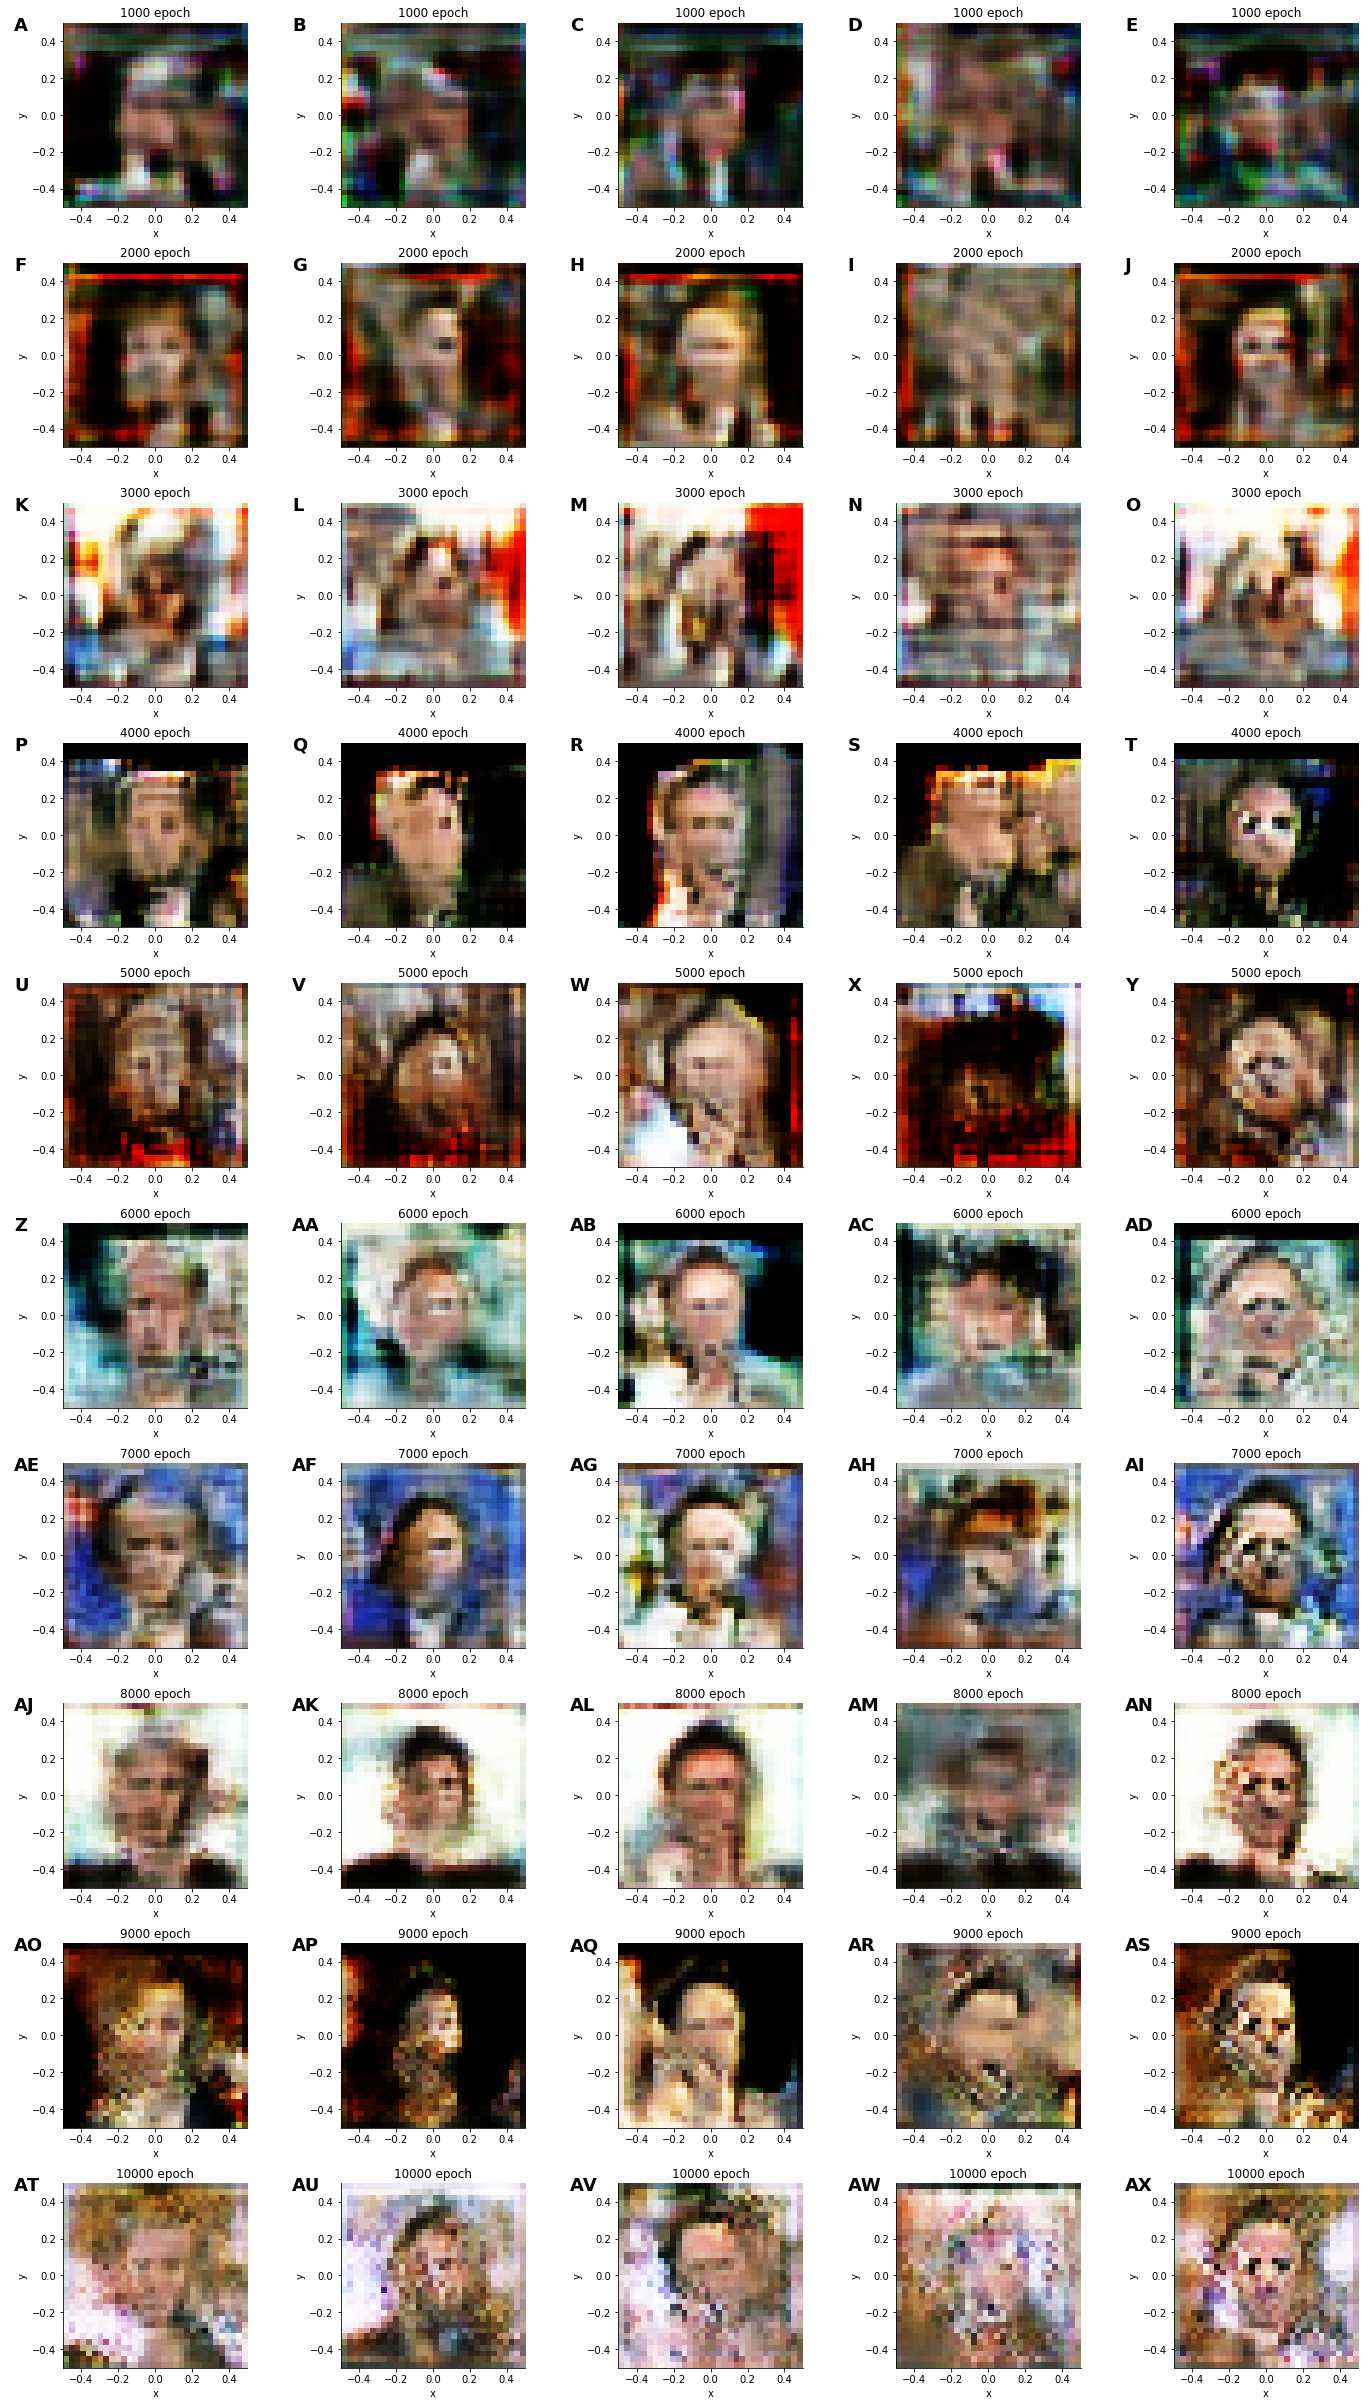

In [6]:
import holoviews as hv
hv.notebook_extension()
for j in range(1, 11):
    y = np_samples[j]
    for i in range(5):
        if j == 1 and i == 0:
            hv_points = hv.RGB(y[i]).relabel(str(j*1000)+' epoch')
        else:
            hv_points += hv.RGB(y[i]).relabel(str(j*1000)+' epoch')
hv_points.cols(5)

:Layout
   .RGB.I       :RGB   [x,y]   (R,G,B)
   .RGB.II      :RGB   [x,y]   (R,G,B)
   .RGB.III     :RGB   [x,y]   (R,G,B)
   .RGB.IV      :RGB   [x,y]   (R,G,B)
   .RGB.V       :RGB   [x,y]   (R,G,B)
   .RGB.VI      :RGB   [x,y]   (R,G,B)
   .RGB.VII     :RGB   [x,y]   (R,G,B)
   .RGB.VIII    :RGB   [x,y]   (R,G,B)
   .RGB.IX      :RGB   [x,y]   (R,G,B)
   .RGB.X       :RGB   [x,y]   (R,G,B)
   .RGB.XI      :RGB   [x,y]   (R,G,B)
   .RGB.XII     :RGB   [x,y]   (R,G,B)
   .RGB.XIII    :RGB   [x,y]   (R,G,B)
   .RGB.XIV     :RGB   [x,y]   (R,G,B)
   .RGB.XV      :RGB   [x,y]   (R,G,B)
   .RGB.XVI     :RGB   [x,y]   (R,G,B)
   .RGB.XVII    :RGB   [x,y]   (R,G,B)
   .RGB.XVIII   :RGB   [x,y]   (R,G,B)
   .RGB.XIX     :RGB   [x,y]   (R,G,B)
   .RGB.XX      :RGB   [x,y]   (R,G,B)
   .RGB.XXI     :RGB   [x,y]   (R,G,B)
   .RGB.XXII    :RGB   [x,y]   (R,G,B)
   .RGB.XXIII   :RGB   [x,y]   (R,G,B)
   .RGB.XXIV    :RGB   [x,y]   (R,G,B)
   .RGB.XXV     :RGB   [x,y]   (R,G,B)
   .RGB.XXVI    :RGB   [x,y]   (R,G,B)
   .RGB.XXVII   :RGB   [x,y]   (R,G,B)
   .RGB.XXVIII  :RGB   [x,y]   (R,G,B)
   .RGB.XXIX    :RGB   [x,y]   (R,G,B)
   .RGB.XXX     :RGB   [x,y]   (R,G,B)
   .RGB.XXXI    :RGB   [x,y]   (R,G,B)
   .RGB.XXXII   :RGB   [x,y]   (R,G,B)
   .RGB.XXXIII  :RGB   [x,y]   (R,G,B)
   .RGB.XXXIV   :RGB   [x,y]   (R,G,B)
   .RGB.XXXV    :RGB   [x,y]   (R,G,B)
   .RGB.XXXVI   :RGB   [x,y]   (R,G,B)
   .RGB.XXXVII  :RGB   [x,y]   (R,G,B)
   .RGB.XXXVIII :RGB   [x,y]   (R,G,B)
   .RGB.XXXIX   :RGB   [x,y]   (R,G,B)
   .RGB.XL      :RGB   [x,y]   (R,G,B)
   .RGB.XLI     :RGB   [x,y]   (R,G,B)
   .RGB.XLII    :RGB   [x,y]   (R,G,B)
   .RGB.XLIII   :RGB   [x,y]   (R,G,B)
   .RGB.XLIV    :RGB   [x,y]   (R,G,B)
   .RGB.XLV     :RGB   [x,y]   (R,G,B)
   .RGB.XLVI    :RGB   [x,y]   (R,G,B)
   .RGB.XLVII   :RGB   [x,y]   (R,G,B)
   .RGB.XLVIII  :RGB   [x,y]   (R,G,B)
   .RGB.XLIX    :RGB   [x,y]   (R,G,B)
   .RGB.L       :RGB   [x,y]   (R,G,B)
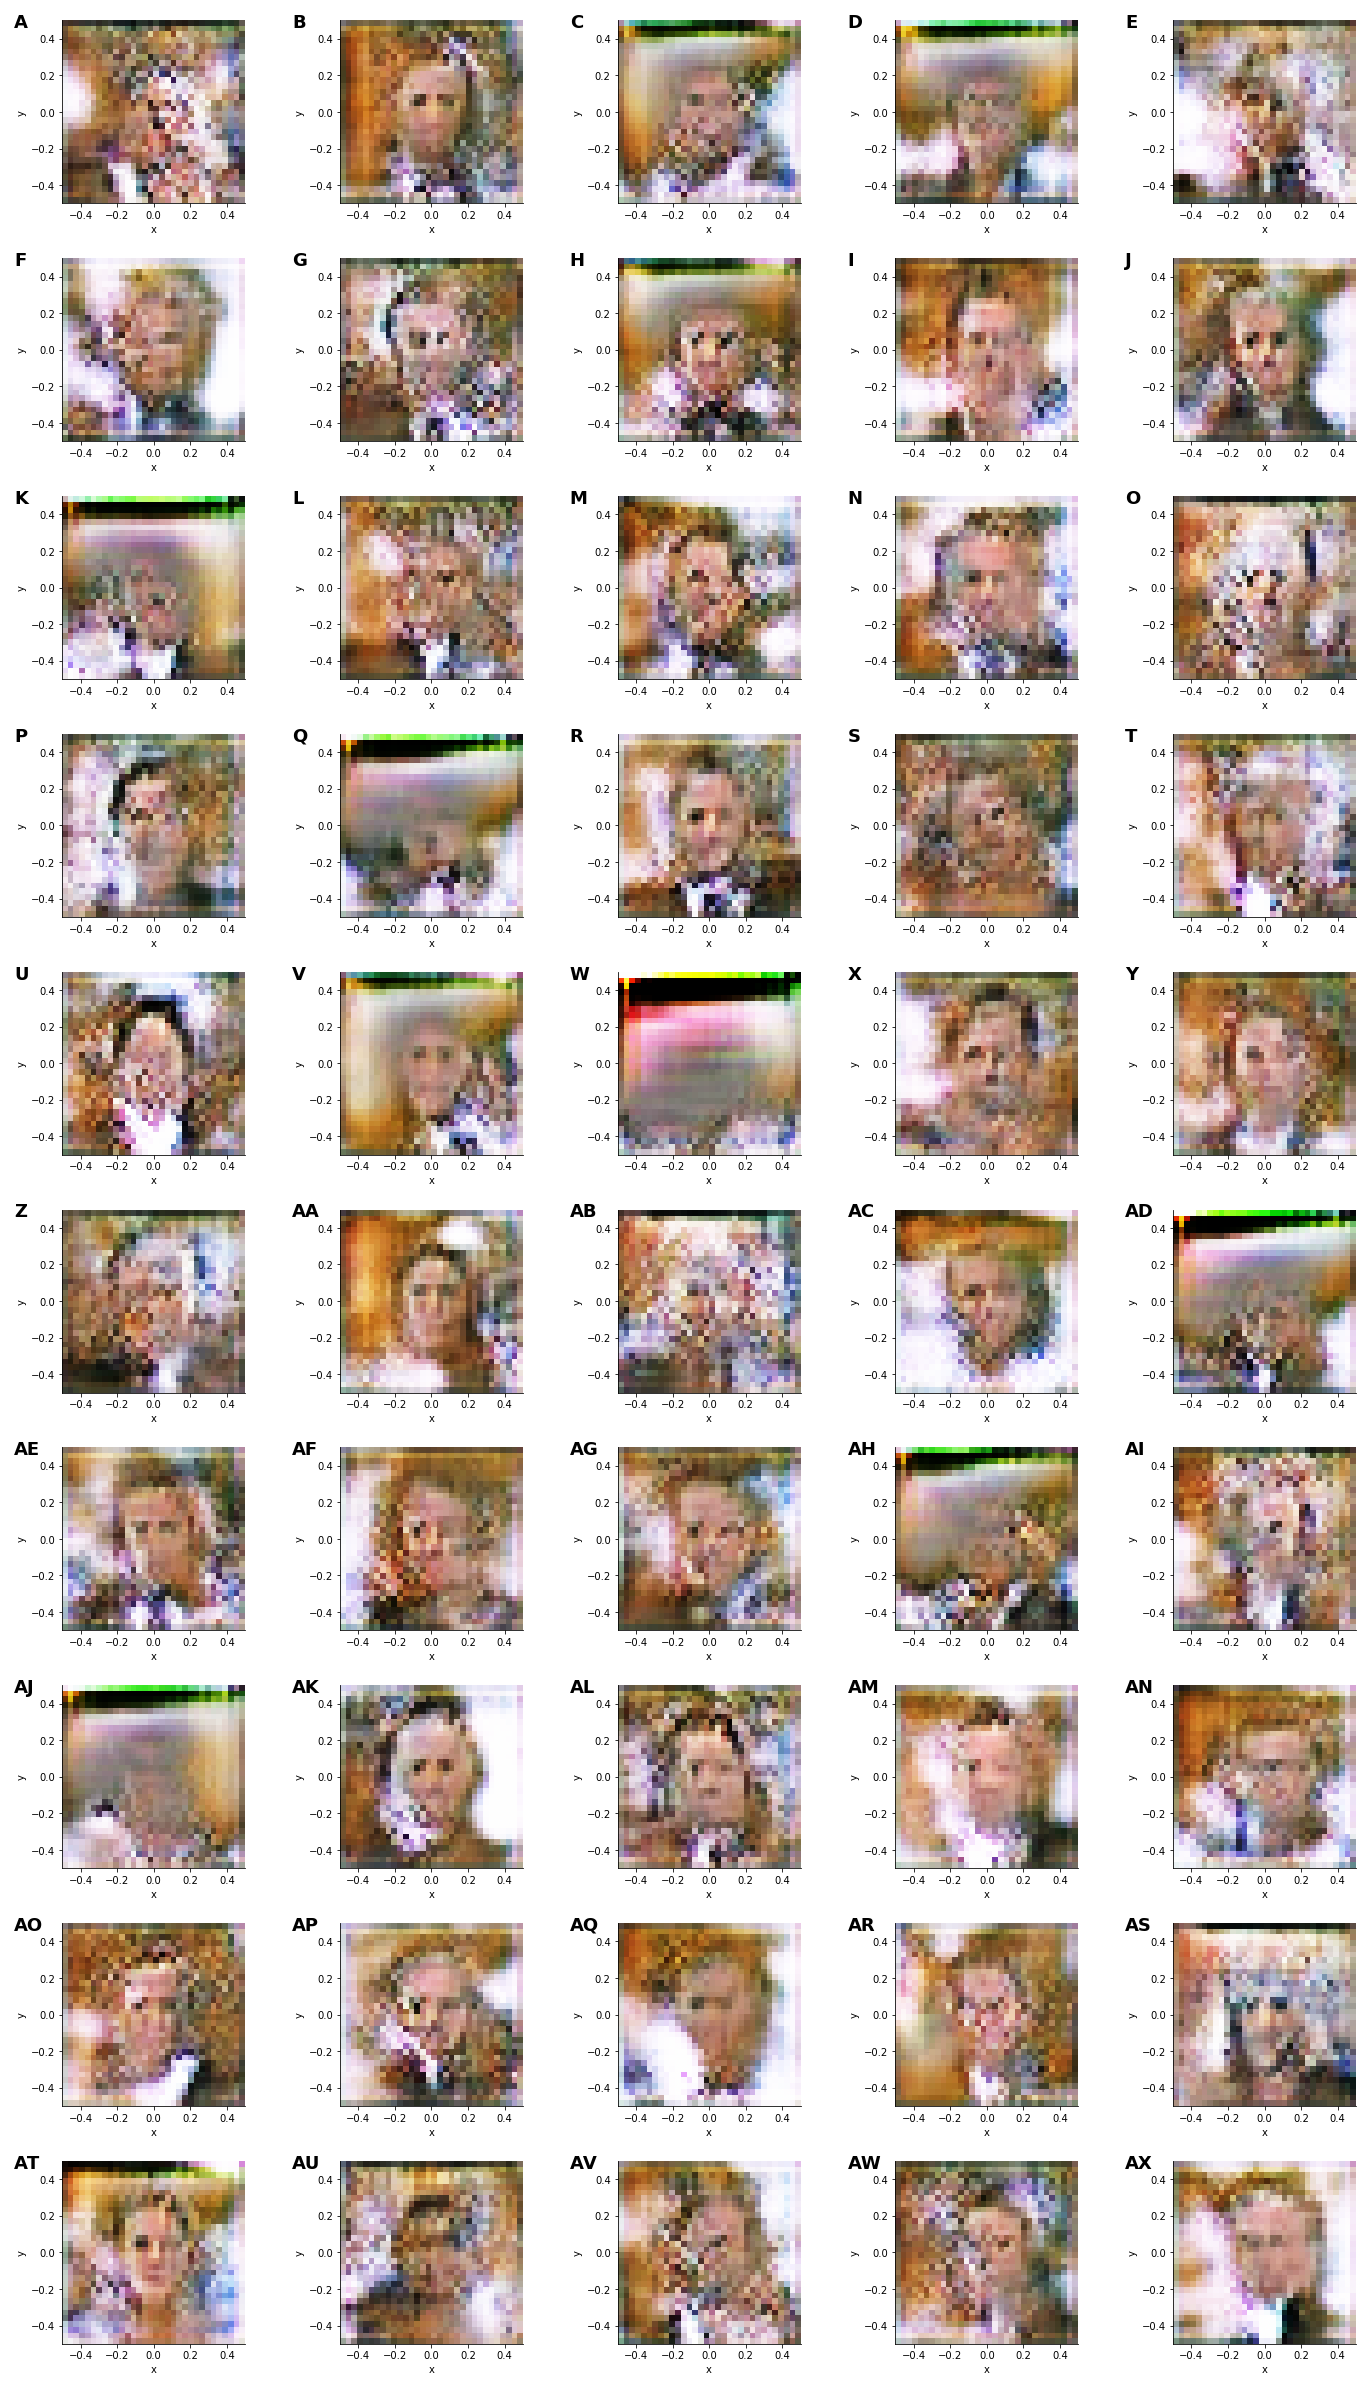

In [7]:
noise = np.random.normal(0, 1, (50, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)
y = ((0.5 * gen_imgs + 0.5) * 255).astype(np.uint8)
for j in range(50):
    if j == 0:
        hv_points = hv.RGB(y[j])
    else:
        hv_points += hv.RGB(y[j])
hv_points.cols(5)